In [6]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pytz import timezone
import csv
from time import sleep
from kafka import KafkaConsumer
from json import loads
import datetime as dt

In [7]:
def connect_kafka_consumer(topic):
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, 
                                   auto_offset_reset='latest', 
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer


def init_plots():
    try:
        width = 10
        height = 6
        fig = plt.figure(figsize=(width,height))
        ax = fig.add_subplot(111) 
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() 
        fig.canvas.draw() 
        return fig, ax
    except Exception as ex:
        print(str(ex))
        
        

%matplotlib notebook


def consume_messages(consumer,fig,ax):
    try:
        print('waiting for messages')
        msg = pd.DataFrame()
        for message in consumer:
            data = pd.DataFrame(message.value)
            data['ts']=int(dt.datetime.now(timezone('UTC')).timestamp())   
            msg = msg.append(data)
            
            t_0 = dt.datetime.utcfromtimestamp(int(list(msg['ts'])[0])).strftime('%M')
            t_1 = dt.datetime.utcfromtimestamp(int(list(msg['ts'])[-1])).strftime('%M')
               
            if True:
                ax.clear()
                temp = msg.groupby(['machine','ts']).count().reset_index()
                for i in range(0,len(temp)):
                    temp.loc[i,'ts'] = str(dt.datetime.utcfromtimestamp(int(temp.loc[i,'ts'])).strftime('%H:%M:%S'))
                mach4 = temp[temp['machine']=='4']
                mach5 = temp[temp['machine']=='5']
                mach6 = temp[temp['machine']=='6']
                mach7 = temp[temp['machine']=='7']
                mach8 = temp[temp['machine']=='8']
                plt.plot(mach4['ts'],mach4['sequence'], label = '4', c='blue')
                plt.plot(mach5['ts'],mach5['sequence'], label = '5', c='green')
                plt.plot(mach6['ts'],mach6['sequence'], label = '6', c='black')
                plt.plot(mach7['ts'],mach7['sequence'], label = '7', c='red')
                plt.plot(mach8['ts'],mach8['sequence'], label = '8', c='purple')
                plt.xticks(rotation=45)



                ax.set_title("Process Count Streaming ")
                ax.set_xlabel("Processing_Time_Process")
                ax.set_ylabel("Count_defined")
                ax.legend()
                fig.show()
                fig.canvas.draw()
                if abs(int(t_1)-int(t_0)) >= 2:
                    msg = msg[msg['ts'] !=list(msg['ts'])[0]].copy()
        plt.close('all')

    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


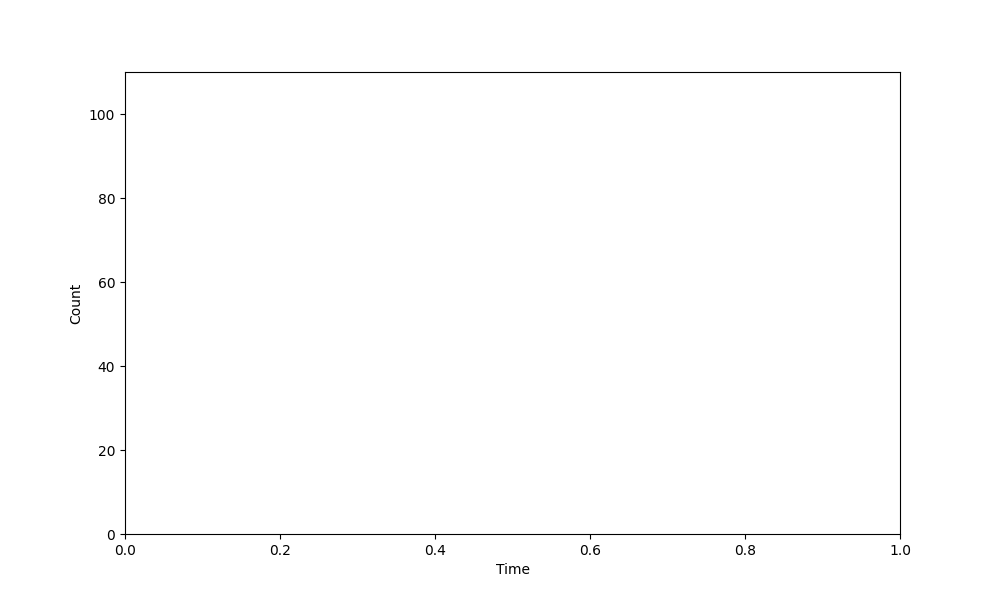

waiting for messages


In [8]:
if __name__ == '__main__':
    topic = 'process'
    consumer = connect_kafka_consumer(topic)
    
    fig, ax = init_plots()
    consume_messages(consumer, fig,ax)